In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import os
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import glob
from sklearn.preprocessing import StandardScaler

In [141]:
#Download Index data from YahooFinance
# Data Span: (1998-2019)
indexes = ["^GSPC", "^FTLC", "^HSI", "^N225", "000001.SS", "^SSMI", "^BSESN", "^GDAXI", "^FCHI", "^BVSP"]
all_index_df = pd.DataFrame()
all_index_original_df = pd.DataFrame()
path = "./data/index/"
for index in indexes:
    index_df = yf.download(tickers=index, start="1996-01-01", end="2019-12-31", interval="1d")
    index_df = index_df.drop(columns=['Open', 'High', 'Low', 'Close'])
    
    # Calculate percentage change for 'Adj Close' and 'Volume'
    index_df['date'] = index_df.index
    index_df['price_change'] = index_df['Adj Close'].pct_change()
    index_df['volume_change'] = index_df['Volume'].pct_change()
    index_df['volatility'] = index_df['Adj Close'].rolling(window=252).std()
    index_df.loc[index_df['Volume'] == 0, 'volume_change'] = 0
    
    # Rename columns
    index_df.rename(columns = {'Adj Close':'price', 'Volume': 'volume'}, inplace = True)
    
    # Save index data to csv
    index_df.to_csv(path + f"{index}_index.csv", index=False)
    print(f"Saved {index}_index.csv")
    
    index_df['index'] = index
    all_index_df = pd.concat([all_index_df, index_df], ignore_index=True)

# Save aggregated index data to csv
all_index_df.to_csv(path + f"all_index.csv", index=False)
print(f"Saved all_index.csv")
    

[*********************100%***********************]  1 of 1 completed
Saved ^GSPC_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^FTLC_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^HSI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^N225_index.csv
[*********************100%***********************]  1 of 1 completed
Saved 000001.SS_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^SSMI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^BSESN_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^GDAXI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^FCHI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^BVSP_index.csv
Saved all_index.csv


## Return

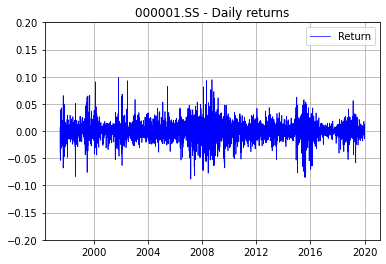

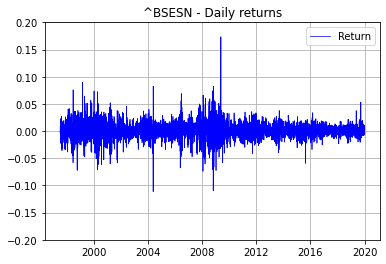

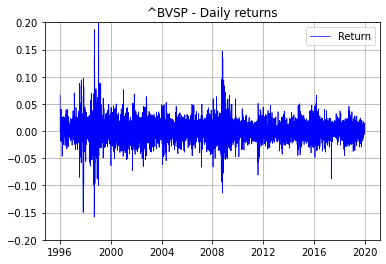

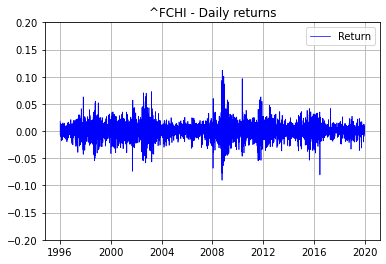

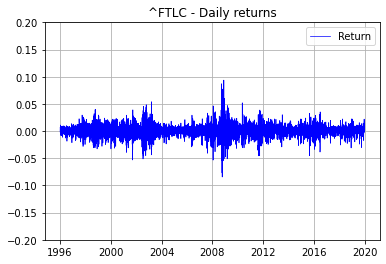

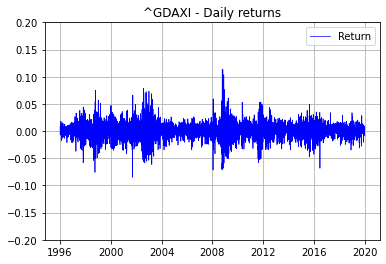

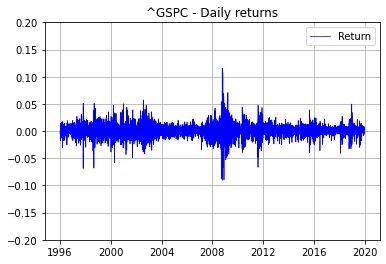

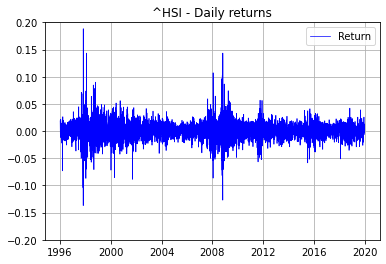

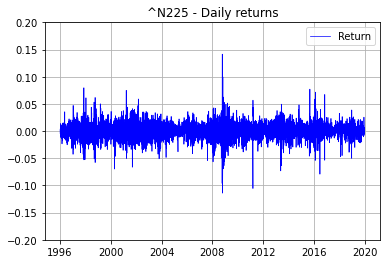

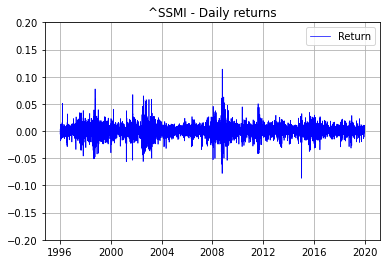

In [118]:
index_grouped = all_index_df.groupby('index')
for name, df in index_grouped:
    df.set_index(df['date'], inplace=True)
    plt.plot(df['price_change'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(name + ' - Daily returns')
    plt.show()

## Drawdown
def: total loss over consequtive days from the last maximum to the next minimum of the price

In [109]:
all_index_df= pd.read_csv("./data/index/all_index.csv")
all_index_df['date'] = pd.to_datetime(all_index_df['date'])

In [110]:
# Create drawdown table
drawdowns_dict = {}
drawdowns_df = []

index_grouped = all_index_df.groupby('index')
for name, index_df in index_grouped:
    index_df = index_df[(index_df['date'].dt.year >= 1998) & (index_df['date'].dt.year <= 2019)] #Only identify drawdown starting from 1998 to 2019
    index_df.set_index(index_df['date'], inplace=True)
    index_change = index_df['price'].diff()
    drawdowns = []
    drawdown_start = None
    dd = 0
    
    for date, price in zip(index_df.index, index_df['price']):
        if drawdown_start is None and index_change[date] < 0:
            drawdown_start = date
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] <= 0:
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] > 0:
            drawdown_end = date
            duration = (drawdown_end - drawdown_start).days
            drawdown = dd / index_df['price'][drawdown_start]
            drawdowns.append((drawdown_start, drawdown_end, duration, drawdown))
            drawdown_start = None
            dd = 0

    # Convert drawdowns list to DataFrame
    drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
    drawdowns_df = drawdowns_df.sort_values(by='drawdown')
    drawdowns_dict[name] = drawdowns_df

print(drawdowns_dict)

{'000001.SS':      drawdown_start drawdown_end  duration  drawdown
1045     2015-08-20   2015-08-27         7 -0.236559
612      2008-06-03   2008-06-16        13 -0.171762
1037     2015-07-01   2015-07-06         5 -0.145622
1036     2015-06-25   2015-06-30         5 -0.140714
633      2008-09-26   2008-10-13        17 -0.129449
...             ...          ...       ...       ...
894      2012-12-19   2012-12-20         1 -0.000104
1118     2016-08-29   2016-08-30         1 -0.000092
1127     2016-10-20   2016-10-21         1 -0.000085
356      2004-02-19   2004-02-20         1 -0.000047
779      2011-02-25   2011-02-28         3 -0.000013

[1321 rows x 4 columns], '^BSESN':      drawdown_start drawdown_end  duration  drawdown
609      2008-10-22   2008-10-29         7 -0.213751
611      2008-11-11   2008-11-21        10 -0.211912
607      2008-10-03   2008-10-13        10 -0.201801
564      2008-01-14   2008-01-23         9 -0.197679
134      2000-04-12   2000-04-25        13 -0.189

In [111]:
# Save drawdown to csv 
all_drawdowns_df = pd.DataFrame()
path = "./data/crashes/"
for index, drawdowns_df in drawdowns_dict.items():
    all_drawdowns_df = pd.concat([all_drawdowns_df, drawdowns_df.assign(index=index)], ignore_index=True)

all_drawdowns_df.to_csv(path + f"all_drawdowns.csv", index=False)
print(f"Saved all_drawdowns.csv")

Saved all_drawdowns.csv


In [112]:
len(all_drawdowns_df)

13704

## Crashes
- 99% percentile of drawdowns
- why not 20% drop?
- change to quarter drop?

In [113]:
# Crash Identification
crashes_dict = {}
for index, dd in drawdowns_dict.items():
    crash_threshold = dd['drawdown'].iloc[round(dd.shape[0] * 0.01)]
    print(index, " crash threshold: ", crash_threshold)
    crash_df = dd[dd['drawdown'] < crash_threshold]
    crash_df.columns = ['crash_start', 'crash_end', 'duration','drawdown']
    crashes_dict[index] = crash_df

000001.SS  crash threshold:  -0.10979286739965652
^BSESN  crash threshold:  -0.11329703117733786
^BVSP  crash threshold:  -0.13787350219930228
^FCHI  crash threshold:  -0.10606975758993163
^FTLC  crash threshold:  -0.08880314033569066
^GDAXI  crash threshold:  -0.11272859686694008
^GSPC  crash threshold:  -0.09279094942661578
^HSI  crash threshold:  -0.10959375375390933
^N225  crash threshold:  -0.09667161887539744
^SSMI  crash threshold:  -0.0962263358753323


In [123]:
# Save crashes to csv 
all_crashes_df = pd.DataFrame()
path = "./data/crashes/"
for index, crashes_df in crashes_dict.items():
    crashes_df.to_csv(path + f"{index}_crahes.csv", index=False)
    print(f"Saved {index}_crashes.csv")
    crashes_df.loc[:, 'index'] = index
    all_crashes_df = pd.concat([all_crashes_df, crashes_df], ignore_index=True)
    
all_crashes_df.to_csv(path + f"all_crashes.csv", index=False)
print(f"Saved all_crashes.csv")

Saved 000001.SS_crashes.csv
Saved ^BSESN_crashes.csv
Saved ^BVSP_crashes.csv
Saved ^FCHI_crashes.csv
Saved ^FTLC_crashes.csv
Saved ^GDAXI_crashes.csv
Saved ^GSPC_crashes.csv
Saved ^HSI_crashes.csv
Saved ^N225_crashes.csv
Saved ^SSMI_crashes.csv
Saved all_crashes.csv


/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_72294/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df.loc[:, 'index'] = index
/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_72294/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df.loc[:, 'index'] = index
/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_72294/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [124]:
# Crashes Count
crash_count = 0
for index, crashes_df in crashes_dict.items():
    crash_count += len(crashes_df)
print(crash_count)

137


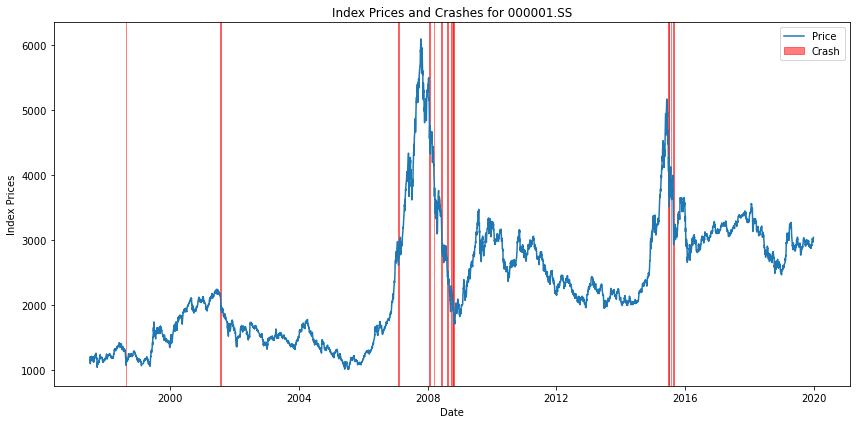

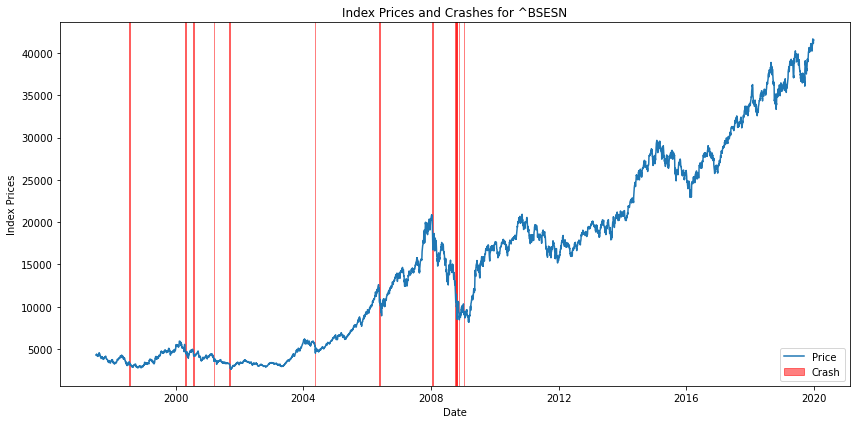

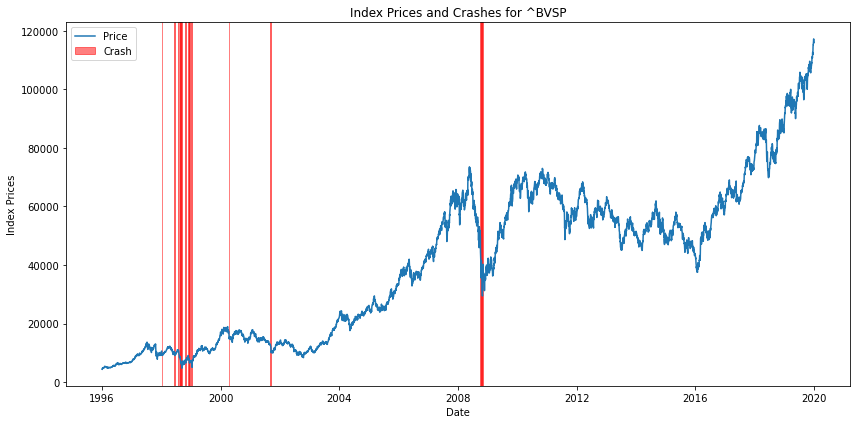

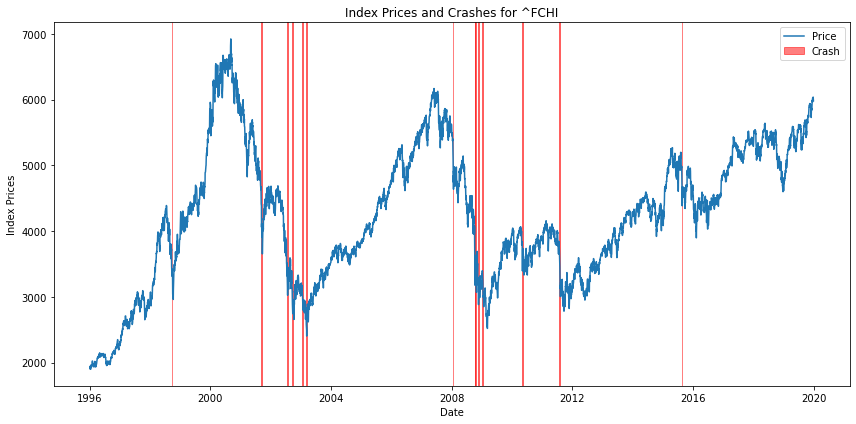

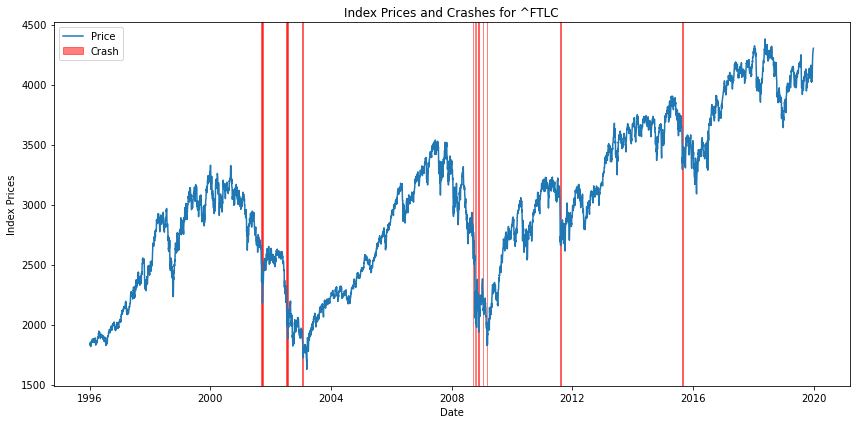

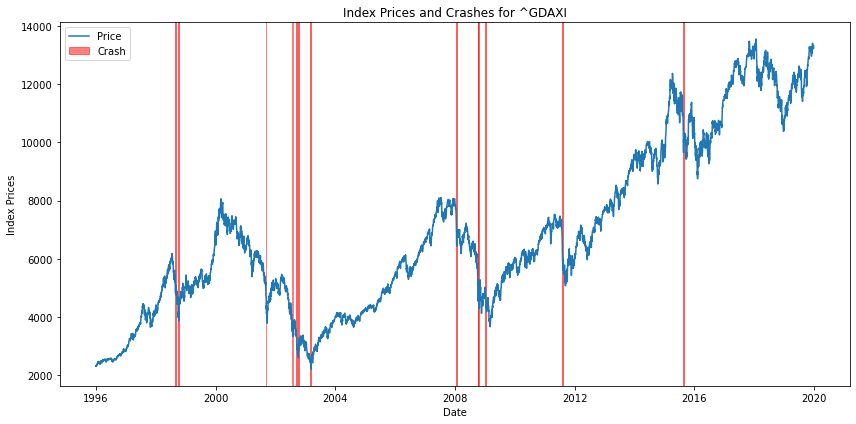

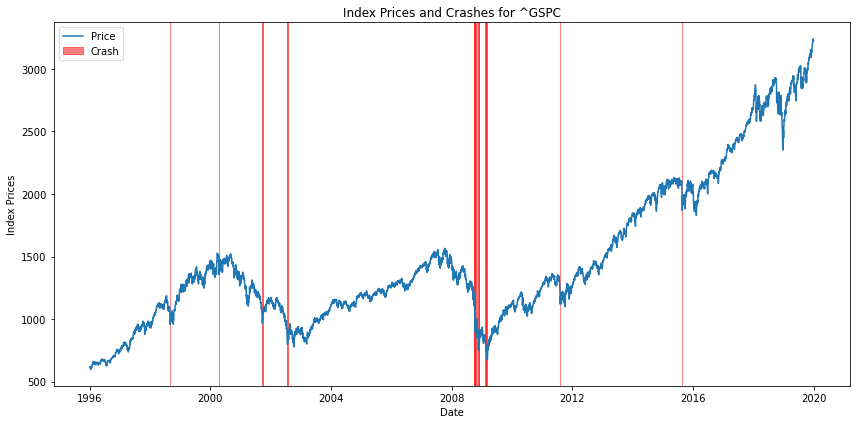

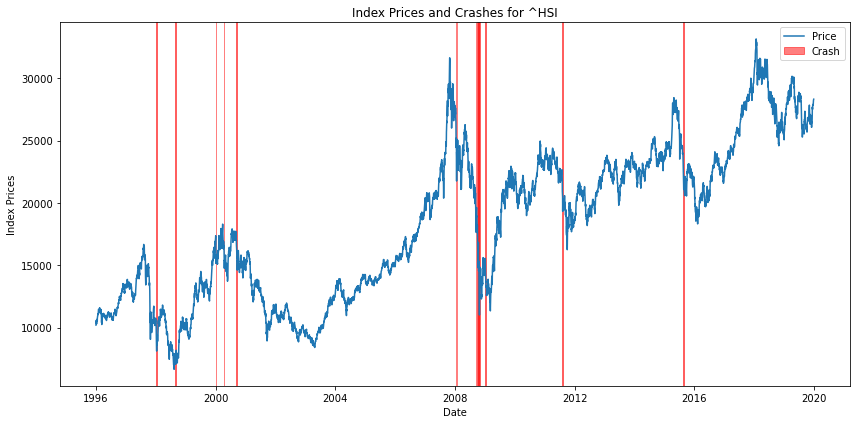

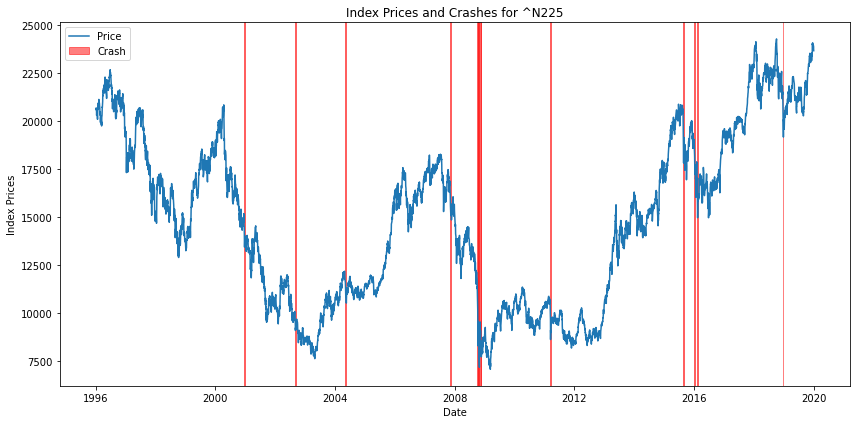

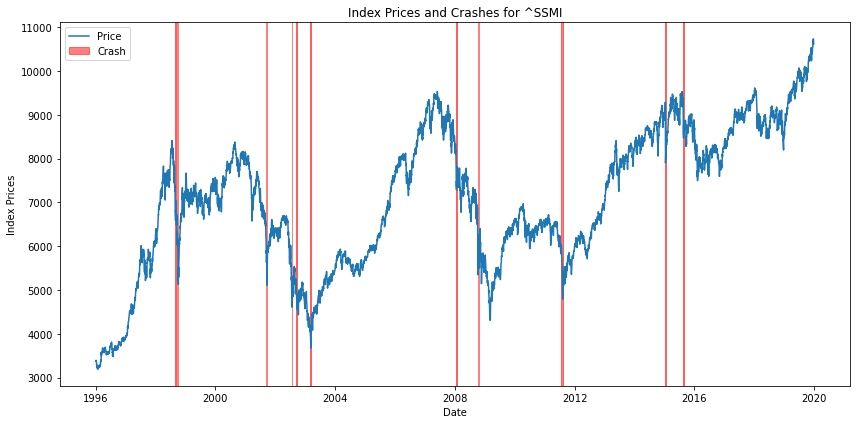

In [125]:
# Plot crashes in graph
index_grouped = all_index_df.groupby('index')
for index, df in index_grouped:
    df.set_index(df['date'], inplace=True)
    index_prices = np.array(df['price'])
    index_dates = np.array(df.index)
    plt.figure(figsize=(12, 6))
    plt.plot(index_dates, index_prices, label=f'{index} Prices')
    
    crashes_df = crashes_dict[index]
    for crash_start, crash_end in zip(crashes_df['crash_start'], crashes_df['crash_end']):
        plt.axvspan(crash_start, crash_end, alpha=0.5, color='red')
    plt.title(f'Index Prices and Crashes for {index}')
    plt.xlabel('Date')
    plt.ylabel('Index Prices')
    plt.legend(['Price', 'Crash'])
    plt.tight_layout()
    plt.show()

## Label the crashes
- we need to label the crashes to each day using all_index_df and all_crashes_df before training them to ML models

In [126]:
# Function to label crashes
def label_crashes(row):
    for index, crash in all_crashes_df.iterrows():
        if crash['crash_start'] <= row['date'] and row['date'] <= crash['crash_end'] and row['index'] == crash['index']:
            return 1
    return 0

# Apply the function to create a new column indicating whether there was a crash
all_index_df['crash_label'] = all_index_df.apply(label_crashes, axis=1)

In [127]:
# View the resulting dataframe
labeled_index_df = all_index_df

# Drop columns
labeled_index_df = labeled_index_df.drop(['price_change', 'volume_change'], axis=1)

In [128]:
# Save as csv
labeled_index_df.to_csv('./data/labeled_data/' + f"daily_labeled_index.csv", index=False)
print(f"Saved daily_labeled_index.csv")

Saved daily_labeled_index.csv


3m, 6m crashes labelling
- Create labels to indicate if crash occurs within next 3 months and 6 months
- To predict a crash on day t, the daily price changes from each day prior to t could be used as a feature

In [167]:
labeled_index_df = pd.read_csv("./data/labeled_data/daily_labeled_index.csv")

In [168]:
# Resample to quarterly data
labeled_index_grouped = labeled_index_df.groupby('index')
quarterly_labeled_index = pd.DataFrame()

for name, df in labeled_index_grouped:
    df['date'] = pd.to_datetime(df['date'])
    quarterly_df = df.set_index('date').resample('Q').agg({
    'price': 'last',
    'volume': 'sum',
    'volatility': 'mean',
    'index': 'last',
    'crash_label': 'any'
    })
    quarterly_df['price_change'] = quarterly_df['price'].pct_change()
    quarterly_df['volume_change'] = quarterly_df['volume'].pct_change()
    quarterly_df['crash_label'] = quarterly_df['crash_label'].astype(int)
    quarterly_df['date'] = quarterly_df.index
    quarterly_labeled_index = pd.concat([quarterly_labeled_index, quarterly_df], ignore_index=True)

In [169]:
quarterly_labeled_index.loc[quarterly_labeled_index['volume'] == 0, 'volume_change'] = 0
quarterly_labeled_index = quarterly_labeled_index.drop(['price', 'volume'], axis=1)
quarterly_labeled_index = quarterly_labeled_index[quarterly_labeled_index['date'].dt.year >= 1998]
quarterly_labeled_index

,volatility,index,crash_label,price_change,volume_change,date
2,NaN,000001.SS,0,0.040963,0.000000,1998-03-31
3,NaN,000001.SS,0,0.077381,0.000000,1998-06-30
4,87.248657,000001.SS,1,-0.071913,0.000000,1998-09-30
5,79.124228,000001.SS,0,-0.077397,0.000000,1998-12-31
6,81.804793,000001.SS,0,0.009901,0.000000,1999-03-31
...,...,...,...,...,...,...
943,275.287884,^SSMI,0,-0.072479,0.344071,2018-12-31
944,223.361272,^SSMI,0,0.124392,-0.064293,2019-03-31
945,324.854218,^SSMI,0,0.044356,-0.030917,2019-06-30
946,424.390936,^SSMI,0,0.018193,0.288380,2019-09-30


In [172]:
# Fill NaN values for volatility column
mean_volatility_SS = quarterly_labeled_index[quarterly_labeled_index['index'] == '000001.SS'].loc[quarterly_labeled_index['date'].dt.year == 1998, 'volatility'].mean()
mean_volatility_BSESN = quarterly_labeled_index[quarterly_labeled_index['index'] == '^BSESN'].loc[quarterly_labeled_index['date'].dt.year == 1998, 'volatility'].mean()

quarterly_labeled_index['volatility'] = quarterly_labeled_index.apply(lambda row: mean_volatility_SS if pd.isna(row['volatility']) and row['index'] == '000001.SS' else row['volatility'], axis=1)
quarterly_labeled_index['volatility'] = quarterly_labeled_index.apply(lambda row: mean_volatility_BSESN if pd.isna(row['volatility']) and row['index'] == '^BSESN' else row['volatility'], axis=1)


In [173]:
quarterly_labeled_index

,volatility,index,crash_label,price_change,volume_change,date
2,83.186443,000001.SS,0,0.040963,0.000000,1998-03-31
3,83.186443,000001.SS,0,0.077381,0.000000,1998-06-30
4,87.248657,000001.SS,1,-0.071913,0.000000,1998-09-30
5,79.124228,000001.SS,0,-0.077397,0.000000,1998-12-31
6,81.804793,000001.SS,0,0.009901,0.000000,1999-03-31
...,...,...,...,...,...,...
943,275.287884,^SSMI,0,-0.072479,0.344071,2018-12-31
944,223.361272,^SSMI,0,0.124392,-0.064293,2019-03-31
945,324.854218,^SSMI,0,0.044356,-0.030917,2019-06-30
946,424.390936,^SSMI,0,0.018193,0.288380,2019-09-30


In [175]:
# Save as csv
quarterly_labeled_index.to_csv('./data/labeled_data/' + f"quarterly_labeled_index.csv", index=False)
print(f"Saved quarterly_labeled_index.csv")

Saved quarterly_labeled_index.csv


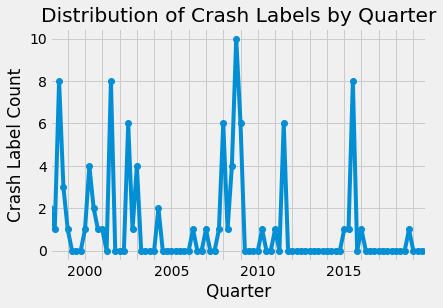

In [122]:
quarterly_labeled_index = pd.read_csv("./data/labeled_data/quarterly_labeled_index.csv")

# Convert the 'date' column to datetime format
quarterly_labeled_index['date'] = pd.to_datetime(quarterly_labeled_index['date'])

# Set the 'date' column as the index
quarterly_labeled_index.set_index('date', inplace=True)

# Resample the data to quarterly frequency and calculate the sum of crash labels for each quarter
quarterly_crash_labels = quarterly_labeled_index['crash_label'].resample('Q').sum()

# Plot the distribution of crash labels by quarter as a line chart
fig, ax = plt.subplots()
quarterly_crash_labels.plot(kind='line', ax=ax, marker='o')
plt.xlabel('Quarter')
plt.ylabel('Crash Label Count')
plt.title('Distribution of Crash Labels by Quarter')

# Show x-labels once per year
ax.xaxis.set_major_locator(plt.MaxNLocator(len(quarterly_crash_labels.index.year.unique())))

plt.show()

## Add Quarter Column
- Quarter column will be used for merging feature set

In [4]:
quarterly_labeled_index = pd.read_csv("./data/labeled_data/quarterly_labeled_index.csv")

quarterly_labeled_index['date'] = pd.to_datetime(quarterly_labeled_index['date'])
quarterly_labeled_index['Quarter'] = quarterly_labeled_index['date'].dt.to_period('Q')
quarterly_labeled_index['Quarter'] = 'Q' + quarterly_labeled_index['Quarter'].astype(str).str[-1] + ' ' + quarterly_labeled_index['Quarter'].astype(str).str[:4]

# Save as csv
quarterly_labeled_index.to_csv('./data/labeled_data/' + f"quarterly_labeled_index.csv", index=False)
print(f"Saved quarterly_labeled_index.csv")

Saved quarterly_labeled_index.csv


## One Hot Encoding

- Label Encoding is suitable when there is an intrinsic order in the categories, whereas One-Hot Encoding is better for nominal categories.

In [12]:
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(quarterly_labeled_index[['index']])


encoded_df = pd.concat([quarterly_labeled_index, pd.DataFrame(encoded_features, columns=encoder.categories_[0])], axis=1)
encoded_df

,volatility,index,crash_label,price_change,volume_change,date,Quarter,000001.SS,^BSESN,^BVSP,^FCHI,^FTLC,^GDAXI,^GSPC,^HSI,^N225,^SSMI
0,83.186443,000001.SS,0,0.040963,0.000000,1998-03-31,Q1 1998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,83.186443,000001.SS,0,0.077381,0.000000,1998-06-30,Q2 1998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87.248657,000001.SS,1,-0.071913,0.000000,1998-09-30,Q3 1998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79.124228,000001.SS,0,-0.077397,0.000000,1998-12-31,Q4 1998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,81.804793,000001.SS,0,0.009901,0.000000,1999-03-31,Q1 1999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,275.287884,^SSMI,0,-0.072479,0.344071,2018-12-31,Q4 2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
876,223.361272,^SSMI,0,0.124392,-0.064293,2019-03-31,Q1 2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
877,324.854218,^SSMI,0,0.044356,-0.030917,2019-06-30,Q2 2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
878,424.390936,^SSMI,0,0.018193,0.288380,2019-09-30,Q3 2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
encoded_df.to_csv('./data/labeled_data/' + f"quarterly_encoded_labeled_index.csv", index=False)
print(f"Saved quarterly_encoded_labeled_index.csv")

Saved quarterly_encoded_labeled_index.csv


## Adding Features

In [66]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("./data/labeled_data/quarterly_encoded_labeled_index.csv")

# Concat the index data with features - Q1 1998 - Q4 2019
Marco_folder = "./data/Features_Marco"
Micro_folder = "./data/updatest"
csv_file_pattern = "*.csv"
Marco_csv_files = glob.glob(f"{Marco_folder}/{csv_file_pattern}")
Micro_csv_files = glob.glob(f"{Micro_folder}/{csv_file_pattern}")

#Marco
# Iterate over each CSV file in Marco_csv_files
for file in Marco_csv_files:
    data = pd.read_csv(file)
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
    # Rename the 'Percentage Change' column to the index value
    data.rename(columns={'Percentage Change': new_name}, inplace=True)
    
    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(data,
                                     how='left',
                                     left_on='Quarter',
                                     right_on='Quarter')


#Micro
# Iterate over each CSV file in csv_files
for file in Micro_csv_files:
    data = pd.read_csv(file)

    # Extract the header row and separate the index values
    header = data.columns[1:]  # Assuming the index values are in columns except the first one
    index_values = header.tolist()
    
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
            
    # Create lists for the three columns
    quarter_column = []
    index_column = []
    file_name_column = []

    # Iterate through the data rows
    for row in data.itertuples(index=False):
        quarter = row[0]  # Extract the quarter value
        values = row[1:]  # Extract the values in the row

        # Iterate through the values and extract index and file name
        for index, file_name in zip(index_values, values):
            # Append the values to their respective columns
            quarter_column.append(quarter)
            index_column.append(index)
            file_name_column.append(file_name)

        
    # Create a DataFrame from the columns
    df = pd.DataFrame({'Quarter': quarter_column, 'index': index_column, new_name: file_name_column})


    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(df,
                                        how='left',
                                        left_on=['Quarter', 'index'],
                                        right_on=['Quarter', 'index'])

# Define quarters
quarters = np.sort(labeled_index.index.unique())


## Normalization
Method: Z-Score Standardization


In [68]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

columns_to_remove = ['index', 'crash_label', 'date', 'Quarter','000001.SS','^BSESN','^BVSP','^FCHI','^FTLC','^GDAXI','^GSPC','^HSI','^N225','^SSMI']
features_columns = [column for column in list(labeled_index.columns) if column not in columns_to_remove]

# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features

labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a fu

In [69]:
# Save the merge_file DataFrame to a CSV file
labeled_index.to_csv("./data/labeled_data/quarterly_labeled_features_standardized.csv", index=False)

In [70]:
labeled_index

,volatility,index,crash_label,price_change,volume_change,date,Quarter,000001.SS,^BSESN,^BVSP,...,10YGov_BondYield,current_acct,FX_Rate,turnover,Population,npl,Recession_Indicators,inflation,Unemployment,GDP
date,,,,,,,,,,,,,,,,,,,,,
1998-03-31,-0.628541,000001.SS,0,0.187709,-0.127147,1998-03-31,Q1 1998,1.0,0.0,0.0,...,-0.007242,-0.029370,-0.079493,0.658318,0.574981,0.203637,1.121317,-0.836243,0.066845,0.246733
1998-06-30,-0.628541,000001.SS,0,0.504913,-0.127147,1998-06-30,Q2 1998,1.0,0.0,0.0,...,-0.066319,0.036556,-0.079493,0.658318,0.574981,0.203637,1.121317,1.560507,0.066845,0.246733
1998-09-30,-0.625680,000001.SS,1,-0.795446,-0.127147,1998-09-30,Q3 1998,1.0,0.0,0.0,...,-0.321596,0.037809,-0.079493,0.658318,0.574981,0.203637,1.121317,-0.080964,0.066845,0.246733
1998-12-31,-0.631403,000001.SS,0,-0.843210,-0.127147,1998-12-31,Q4 1998,1.0,0.0,0.0,...,0.231035,0.033007,-0.079493,0.658318,0.574981,0.203637,1.121317,0.048119,0.066845,0.246733
1999-03-31,-0.629515,000001.SS,0,-0.082838,-0.127147,1999-03-31,Q1 1999,1.0,0.0,0.0,...,0.028723,0.019243,-0.079493,-0.324399,0.391240,0.201522,1.121317,0.362132,0.311972,0.173266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,-0.493234,^SSMI,0,-0.800378,-0.127147,2018-12-31,Q4 2018,0.0,0.0,0.0,...,-6.976072,0.025428,-0.079493,0.033040,0.125618,-0.349336,1.121317,-0.199904,-0.082835,-0.032256
2019-03-31,-0.529809,^SSMI,0,0.914383,-0.127147,2019-03-31,Q1 2019,0.0,0.0,0.0,...,0.507654,0.008938,0.400113,-0.311569,0.084730,-0.351040,1.121317,0.122961,-0.487134,-0.569956
2019-06-30,-0.458321,^SSMI,0,0.217264,-0.127147,2019-06-30,Q2 2019,0.0,0.0,0.0,...,2.466357,0.052412,-0.549603,-0.311569,0.084730,2.680854,1.121317,-0.228616,-0.487134,-0.569956


## Create Lagged Features

In [94]:
labeled_index= pd.read_csv("./data/labeled_data/quarterly_labeled_features_standardized.csv")

In [95]:
#Features Columns
features_columns = [
 'volatility',
 'price_change',
 'volume_change',
 'Crude_Oil_Index_Excess_Return',
 'Ted_Rate',
 'Gold_Price',
 'housing',
 'reserve',
 '10YGov_BondYield',
 'current_acct',
 'FX_Rate',
 'turnover',
 'Population',
 'npl',
 'Recession_Indicators',
 'inflation',
 'Unemployment',
 'GDP']

#Features Columns (with label)
features_labal_columns = ['crash_label', 'volatility', 'price_change', 'volume_change', 'Crude_Oil_Index_Excess_Return', 'Ted_Rate', 'Gold_Price', 'housing', 'reserve', '10YGov_BondYield', 'current_acct', 'FX_Rate', 'turnover', 'Population', 'npl', 'Recession_Indicators', 'inflation', 'Unemployment', 'GDP']

# Lag 1 Columns
lag1_features_columns = ['crash_label',
 'volatility_lag1',
 'price_change_lag1',
 'volume_change_lag1',
 'Crude_Oil_Index_Excess_Return_lag1',
 'Ted_Rate_lag1',
 'Gold_Price_lag1',
 'housing_lag1',
 'reserve_lag1',
 '10YGov_BondYield_lag1',
 'current_acct_lag1',
 'FX_Rate_lag1',
 'turnover_lag1',
 'Population_lag1',
 'npl_lag1',
 'Recession_Indicators_lag1',
 'inflation_lag1',
 'Unemployment_lag1',
 'GDP_lag1']

# Lag 2 Columns
lag2_features_columns = ['crash_label',
 'volatility_lag2',
 'price_change_lag2',
 'volume_change_lag2',
 'Crude_Oil_Index_Excess_Return_lag2',
 'Ted_Rate_lag2',
 'Gold_Price_lag2',
 'housing_lag2',
 'reserve_lag2',
 '10YGov_BondYield_lag2',
 'current_acct_lag2',
 'FX_Rate_lag2',
 'turnover_lag2',
 'Population_lag2',
 'npl_lag2',
 'Recession_Indicators_lag2',
 'inflation_lag2',
 'Unemployment_lag2',
 'GDP_lag2']

In [96]:
# Define the lag periods
lag_periods = [1, 2]

# Shift lagged data
labeled_index_grouped = labeled_index.groupby('index')
lagged_labeled_index = pd.DataFrame()

for name, df in labeled_index_grouped:
    for feature_name in features_columns:
        for lag_period in lag_periods:
            lagged_feature_name = f"{feature_name}_lag{lag_period}"
            df[lagged_feature_name] = df[feature_name].shift(lag_period)
    lagged_labeled_index = pd.concat([lagged_labeled_index, df], ignore_index=True)
    
lagged_labeled_index = lagged_labeled_index.dropna()
for feature_name in features_columns:
    lagged_labeled_index.drop(feature_name, axis=1, inplace=True)

In [97]:
lagged_labeled_index.to_csv("./data/labeled_data/lagged_labeled_data.csv", index=False)

## Data Visualization

In [98]:
#Import Dataset
labeled_index = pd.read_csv("./data/labeled_data/quarterly_labeled_features_standardized.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

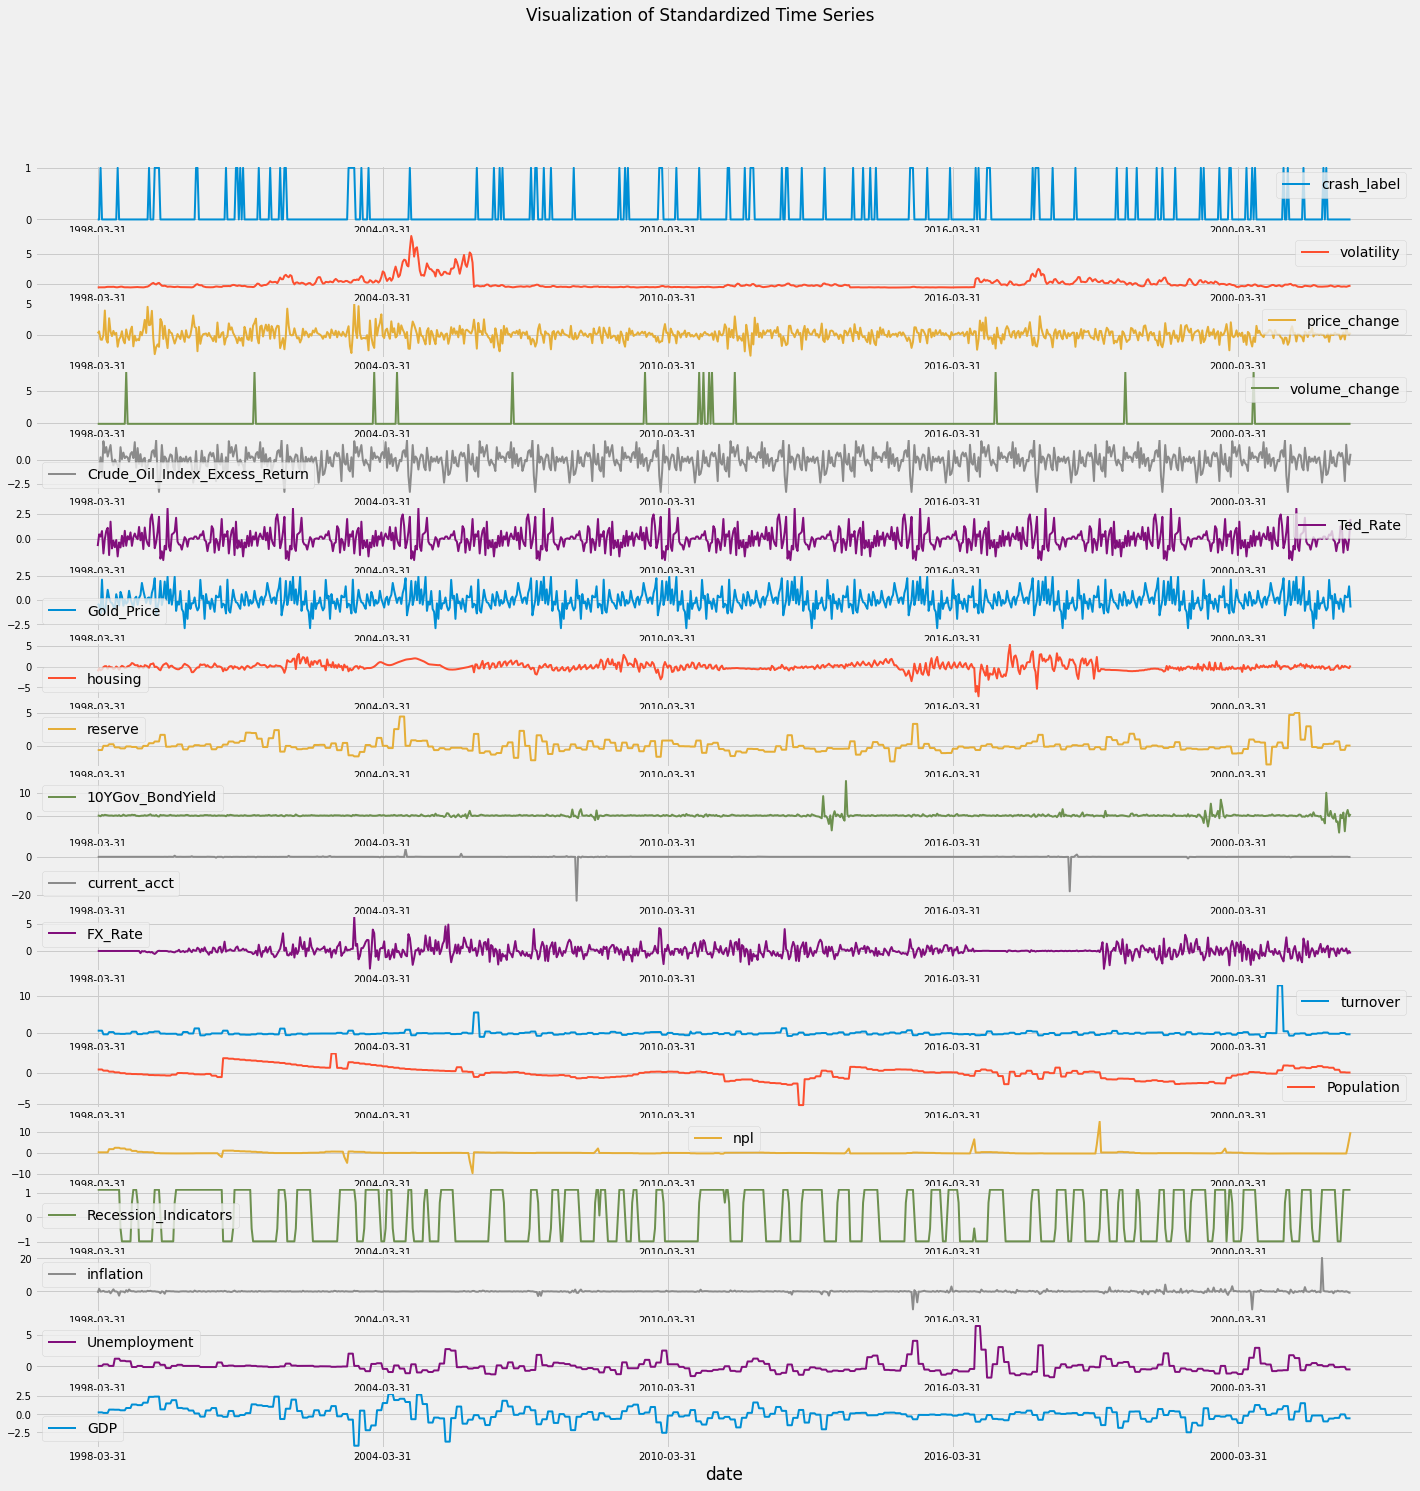

In [99]:
# Plot the time series
plt.style.use('fivethirtyeight')
labeled_index[features_labal_columns].plot(subplots=True,
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of Standardized Time Series')
plt.show()

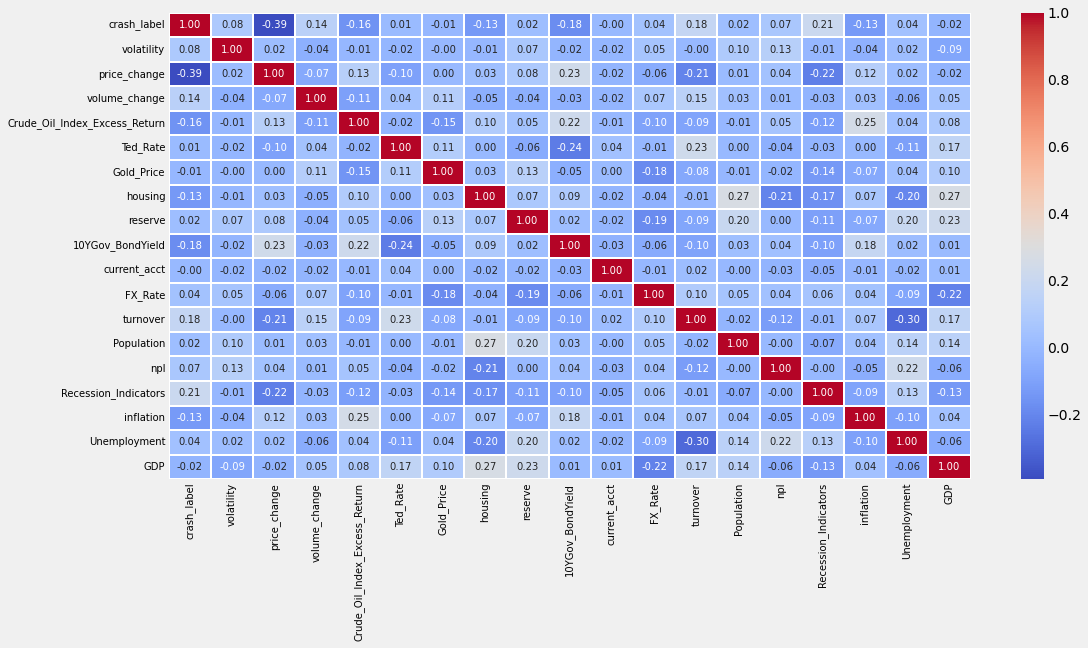

In [100]:
# heatmap visualization of the correlation matrix for features
corr_matrix = labeled_index[features_labal_columns].corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

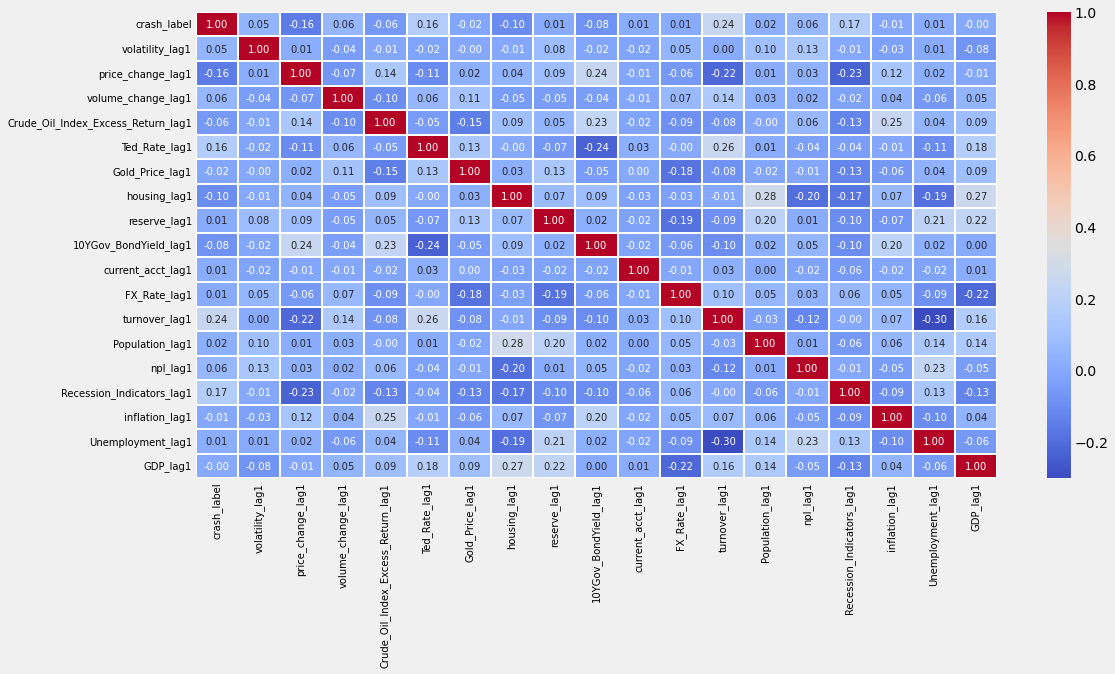

In [101]:
# heatmap visualization of the correlation matrix for lag 1 features
corr_matrix = lagged_labeled_index[lag1_features_columns].corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

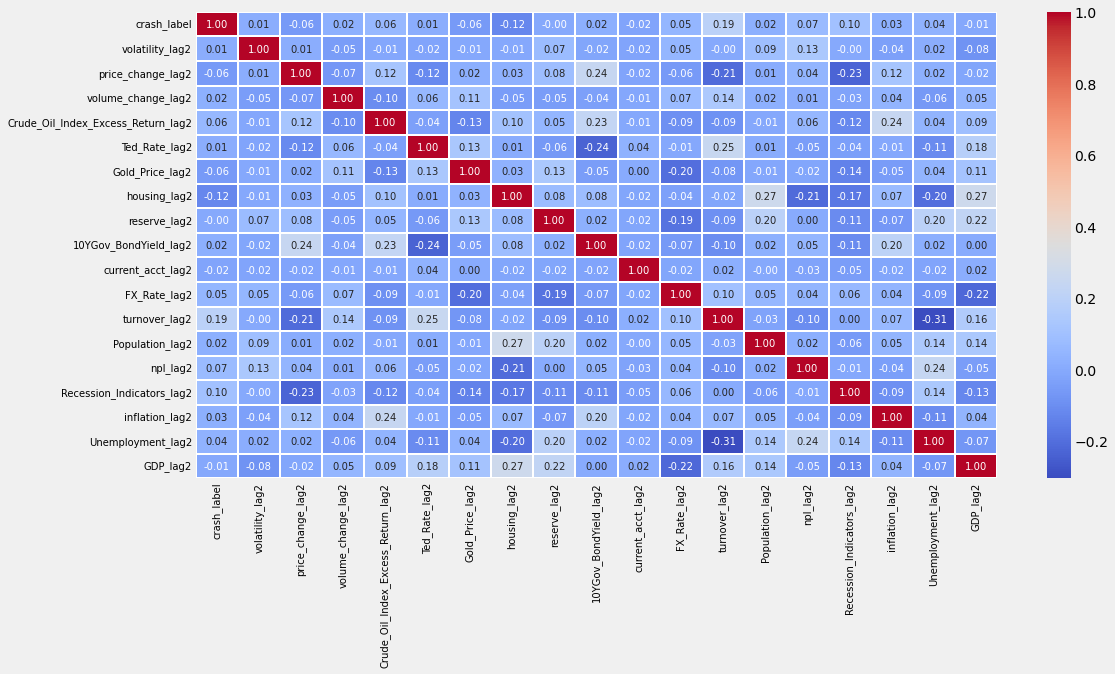

In [102]:
# heatmap visualization of the correlation matrix for lag 2 features
corr_matrix = lagged_labeled_index[lag2_features_columns].corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Dataset imbalances

The rare nature of stock market crash events results in a highly imbalanced dataset. 
Only 10.80% of available sample corresponds to crash events. Imbalanced dataset can influence ML algorithms and biased against the minority class<br>
One of the solutions is apply resampling

In [75]:
quarterly_labeled_index = pd.read_csv("./data/labeled_data/quarterly_labeled_index.csv")
print("Total sample size: ", len(quarterly_labeled_index))
print("Sample size of not crash quarter: ", quarterly_labeled_index['crash_label'].value_counts()[0])
print("Sample size of crash quarter: ", quarterly_labeled_index['crash_label'].value_counts()[1])
print("Percentage of quarterly crash: ", quarterly_labeled_index['crash_label'].value_counts()[1]/len(quarterly_labeled_index))

Total sample size:  880
Sample size of not crash quarter:  785
Sample size of crash quarter:  95
Percentage of quarterly crash:  0.10795454545454546
